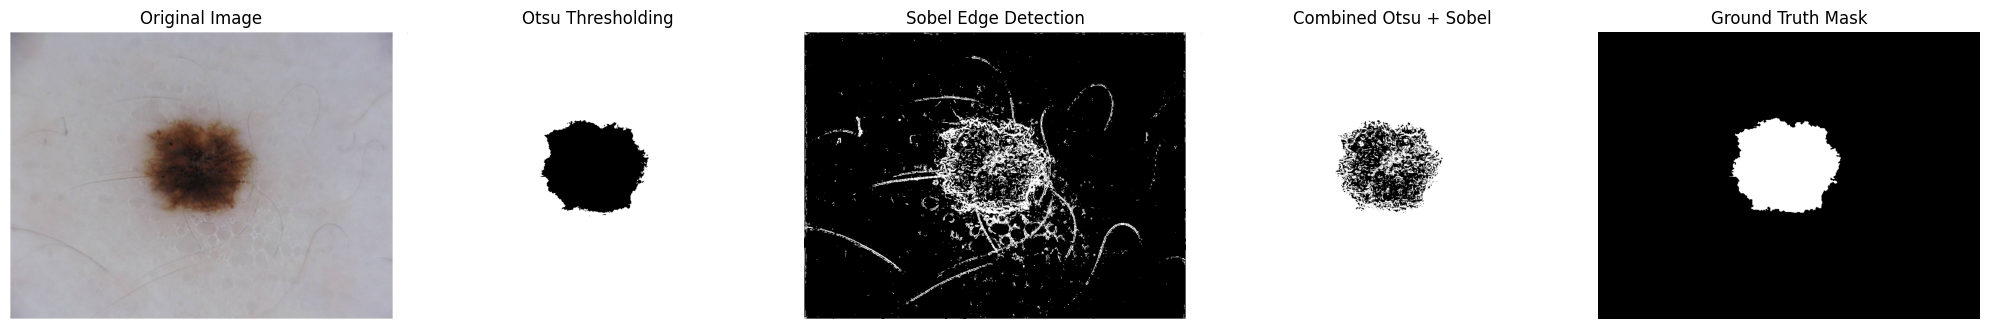

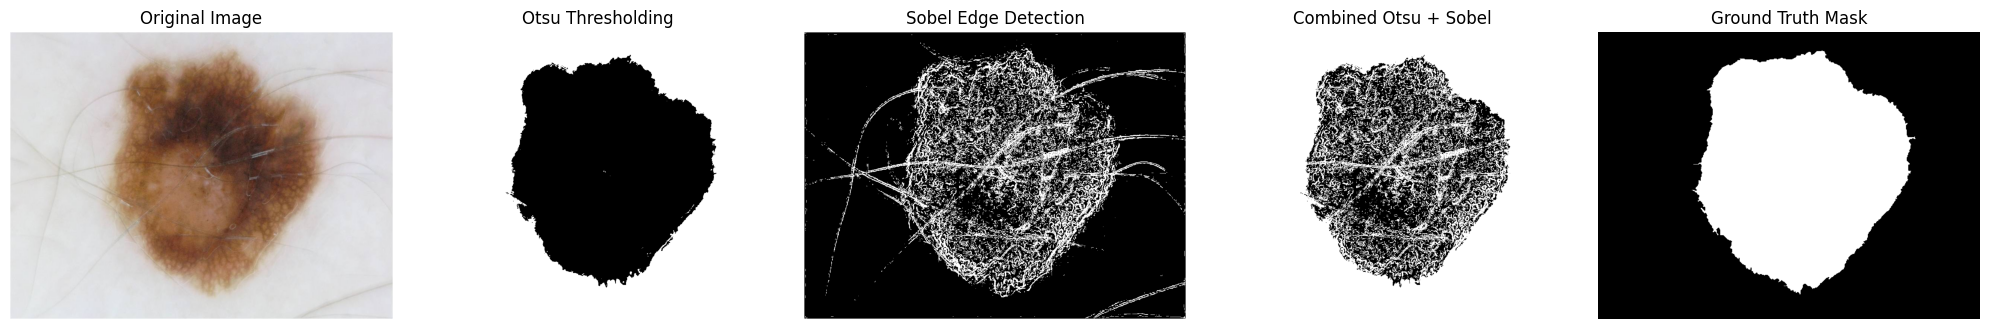

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dataset paths
train_images_dir = 'skin_dataset/ISIC2018_Task1-2_Training_Input'
train_masks_dir = 'skin_dataset/ISIC2018_Task1_Training_GroundTruth'

def load_image_and_mask(image_id):
    image_path = os.path.join(train_images_dir, f"{image_id}.jpg")
    mask_path = os.path.join(train_masks_dir, f"{image_id}_segmentation.png")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    return image, mask

def apply_otsu_sobel(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Sobel Edge Detection
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobel_x, sobel_y)
    sobel_edges = np.uint8(sobel_edges / sobel_edges.max() * 255)

    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    _, sobel_uint8 = cv2.threshold(sobel_magnitude.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    combined = cv2.bitwise_or(otsu_thresh, sobel_uint8)

    return otsu_thresh, sobel_uint8, combined

def visualize_results(image, otsu, sobel, combined, mask):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(otsu, cmap='gray')
    plt.title("Otsu Thresholding")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(sobel, cmap='gray')
    plt.title("Sobel Edge Detection")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(combined, cmap='gray')
    plt.title("Combined Otsu + Sobel")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_id = 'ISIC_0000001'
image, mask = load_image_and_mask(image_id)
otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)

visualize_results(image, otsu_thresh, sobel_edges, combined, mask)

image_id = 'ISIC_0000003'
image, mask = load_image_and_mask(image_id)
otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)
visualize_results(image, otsu_thresh, sobel_edges, combined, mask)


In [2]:
import cv2
import numpy as np

def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    sobel_uint8 = np.uint8(sobel_magnitude / sobel_magnitude.max() * 255)
    _, sobel_thresh = cv2.threshold(sobel_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    otsu_norm = otsu_thresh / 255.0
    sobel_norm = sobel_thresh / 255.0
    
    dual_channel_input = np.stack((otsu_norm, sobel_norm), axis=-1)
    
    return dual_channel_input


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-17 07:45:45.282880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737092745.367567  155717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737092745.394593  155717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 07:45:45.629150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256), max_num=0):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        if max_num == 0: break
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_segmentation.png'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            processed_image = preprocess_image(image)

            images.append(processed_image)
            masks.append(mask / 255.0)  # Normalize mask
            max_num -= 1

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

In [5]:

def build_unet(input_shape=(256, 256, 2)):
    inputs = layers.Input(shape=input_shape)
    
    def conv_block(x, filters, dropout_rate=0.1):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)  # Dropout for regularization
        return x

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)

    u4 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = conv_block(u4, 64)

    u5 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = conv_block(u5, 32)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

In [6]:
X, Y = load_and_preprocess_data(train_images_dir, train_masks_dir, max_num=500)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1737092773.706782  155717 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     32,832 │ dropout_2[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_7[0][0]  

 Total params: 466,241 (1.78 MB)

 Trainable params: 466,241 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("best_light_unet.h5", monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train, 
                     epochs=50, 
                     batch_size=16, 
                     validation_split=0.1, 
                     callbacks=[checkpoint, early_stop])


Epoch 1/50


I0000 00:00:1737092778.422228  156029 service.cc:148] XLA service 0x7ff794057be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737092778.423024  156029 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-17 07:46:18.533253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737092778.994699  156029 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1737092794.858416  156029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6995 - loss: 0.5512

23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 794ms/step - accuracy: 0.7032 - loss: 0.5482 - val_accuracy: 0.8165 - val_loss: 0.4555
Epoch 2/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8438 - loss: 0.4128

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8435 - loss: 0.4116 - val_accuracy: 0.8318 - val_loss: 0.4053
Epoch 3/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8641 - loss: 0.3328

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8634 - loss: 0.3344 - val_accuracy: 0.8418 - val_loss: 0.3808
Epoch 4/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8678 - loss: 0.3281

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8678 - loss: 0.3279 - val_accuracy: 0.8548 - val_loss: 0.3607
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8760 - loss: 0.3158 - val_accuracy: 0.8503 - val_loss: 0.3989
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8723 - loss: 0.3308

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8726 - loss: 0.3302 - val_accuracy: 0.8634 - val_loss: 0.3494
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8871 - loss: 0.2997 - val_accuracy: 0.8688 - val_loss: 0.3529
Epoch 8/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8880 - loss: 0.2947

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8880 - loss: 0.2945 - val_accuracy: 0.8749 - val_loss: 0.3493
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8882 - loss: 0.3032 - val_accuracy: 0.8727 - val_loss: 0.3559
Epoch 10/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8936 - loss: 0.2934

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8940 - loss: 0.2924 - val_accuracy: 0.8755 - val_loss: 0.3311
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8918 - loss: 0.2827 - val_accuracy: 0.8717 - val_loss: 0.3446
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8932 - loss: 0.2900 - val_accuracy: 0.8613 - val_loss: 0.3948
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8789 - loss: 0.3162 - val_accuracy: 0.8783 - val_loss: 0.3330
Epoch 14/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9050 - loss: 0.2619

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9049 - loss: 0.2622 - val_accuracy: 0.8803 - val_loss: 0.3183
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9066 - loss: 0.2539 - val_accuracy: 0.8786 - val_loss: 0.3201
Epoch 16/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8973 - loss: 0.2739

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8976 - loss: 0.2733 - val_accuracy: 0.8821 - val_loss: 0.3159
Epoch 17/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9092 - loss: 0.2518

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9091 - loss: 0.2520 - val_accuracy: 0.8863 - val_loss: 0.2996
Epoch 18/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9075 - loss: 0.2544 - val_accuracy: 0.8840 - val_loss: 0.3102
Epoch 19/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9058 - loss: 0.2584 - val_accuracy: 0.8864 - val_loss: 0.3083
Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9180 - loss: 0.2235 - val_accuracy: 0.8869 - val_loss: 0.3089
Epoch 21/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9070 - loss: 0.2674 - val_accuracy: 0.8808 - val_loss: 0.3028
Epoch 22/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9115 - loss: 0.2444 - val_accuracy: 0.8860 - val_loss: 0.3063


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


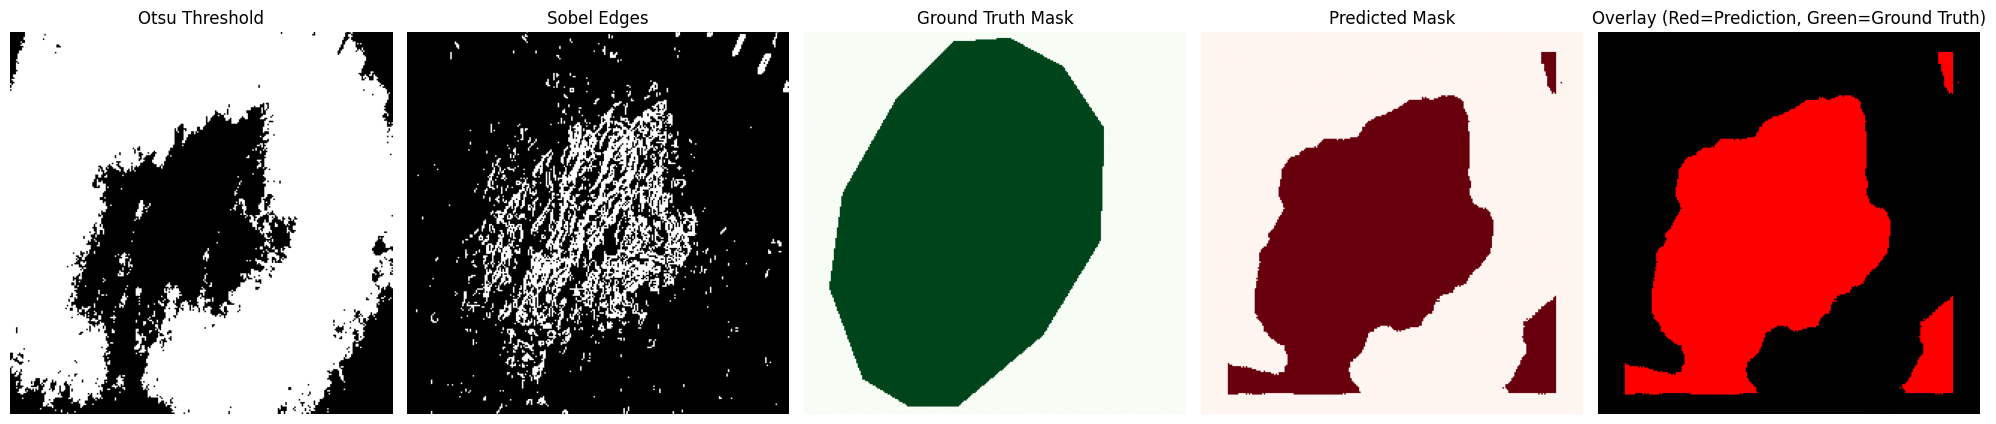

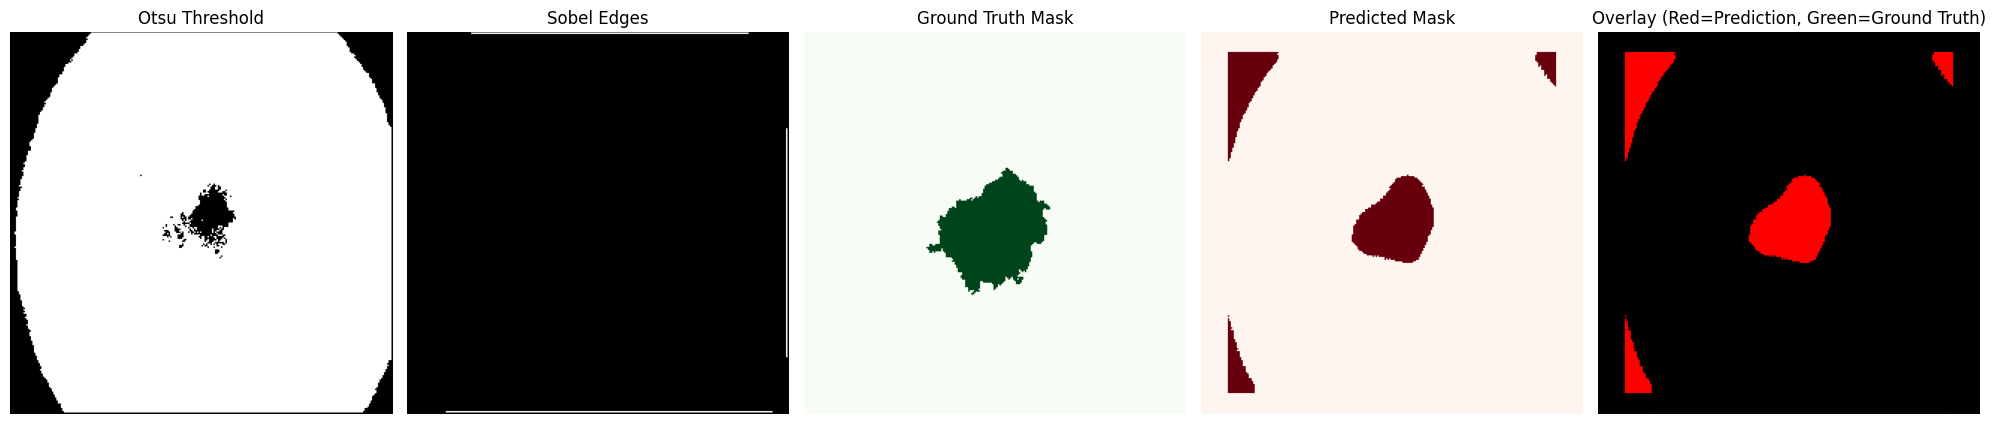

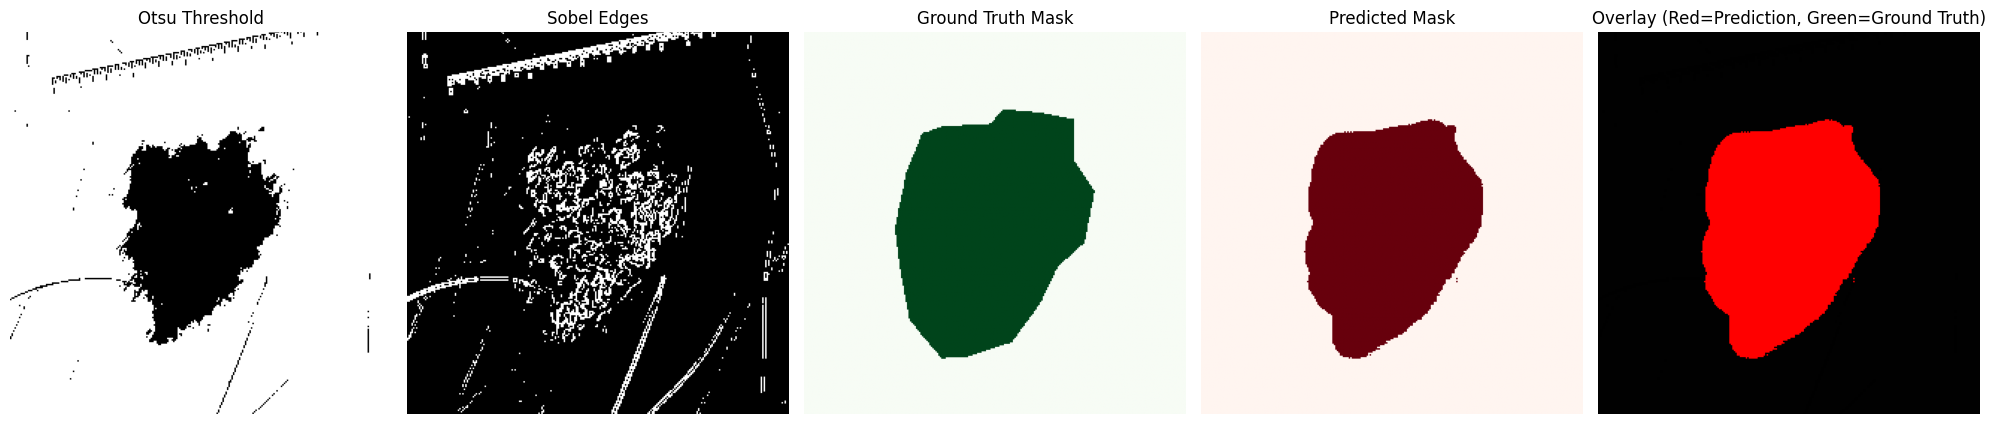

In [8]:
def plot_predictions_with_mask(model, X, Y, threshold=0.5, num_samples=3):
    preds = model.predict(X[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(X[i][:, :, 0], cmap='gray')
        plt.title('Otsu Threshold')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(X[i][:, :, 1], cmap='gray')
        plt.title('Sobel Edges')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        normalized_gt_mask = (Y[i].squeeze() / 255.0)
        plt.imshow(normalized_gt_mask, cmap='Greens') 
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        predicted_mask = (preds[i].squeeze() > threshold).astype(np.uint8)
        plt.imshow(predicted_mask, cmap='Reds')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        overlay = X[i][:, :, 0].copy()
        overlay = np.stack([overlay]*3, axis=-1)
        overlay[predicted_mask == 1] = [255, 0, 0]
        overlay[normalized_gt_mask == 1] = [0, 255, 0]
        plt.imshow(overlay.astype(np.uint8))
        plt.title('Overlay (Red=Prediction, Green=Ground Truth)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


plot_predictions_with_mask(model, X_val, Y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


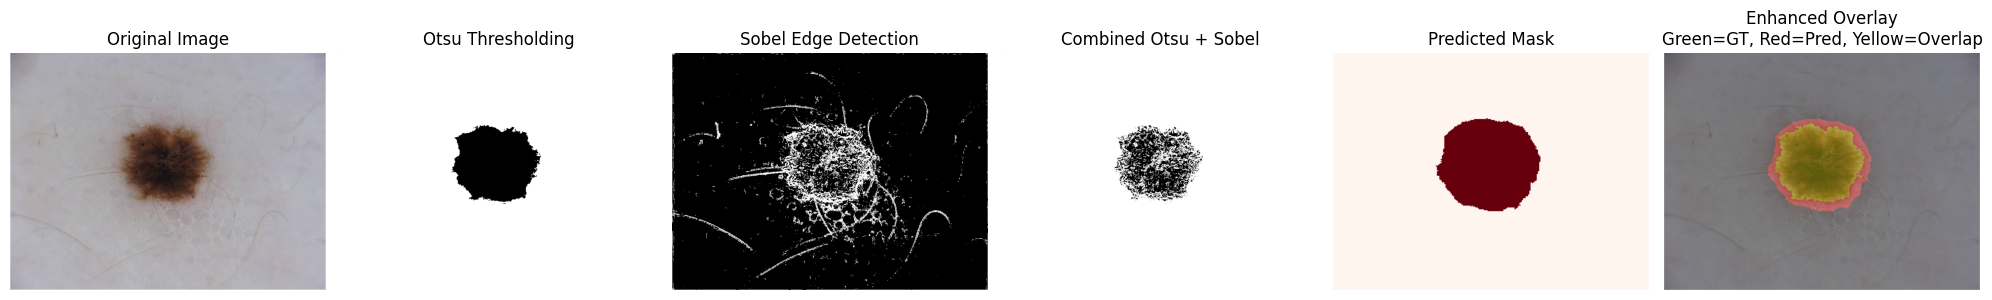

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


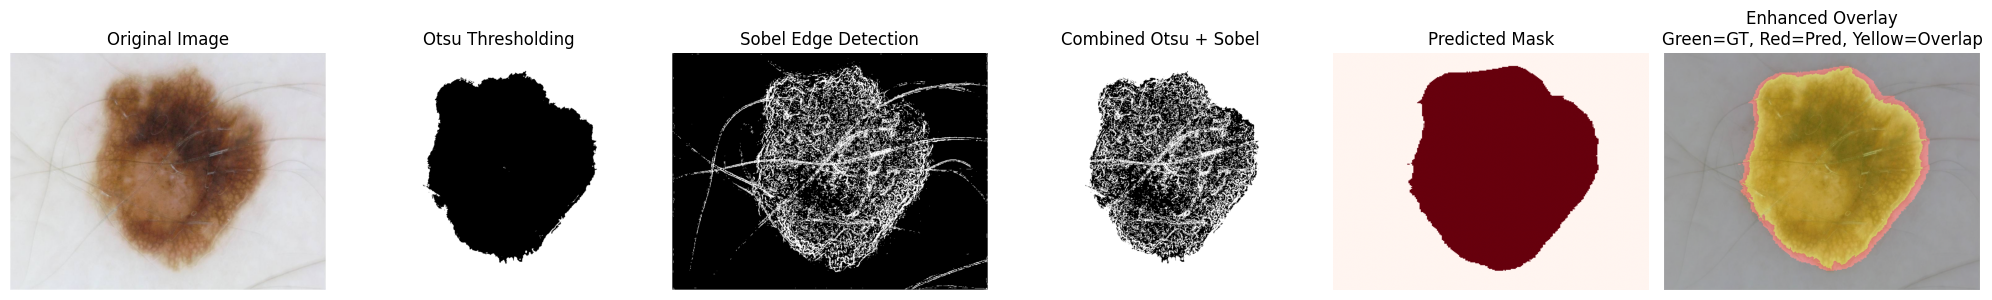

In [9]:

def load_single_image_and_mask(image_id, dataset='train'):
    if dataset == 'train':
        image_dir = 'skin_dataset/ISIC2018_Task1-2_Training_Input'
        mask_dir = 'skin_dataset/ISIC2018_Task1_Training_GroundTruth'
        mask_path = os.path.join(mask_dir, f"{image_id}_segmentation.png")
    else:
        image_dir = 'skin_dataset/ISIC2018_Task1-2_Test_Input'
        mask_path = None

    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path and os.path.exists(mask_path) else None
    
    return image, mask

def visualize_image_with_segmentation_intersection(model, image_id, dataset='train', threshold=0.5):
    image, mask = load_single_image_and_mask(image_id, dataset)
    otsu_thresh, sobel_edges, combined = apply_otsu_sobel(image)

    combined_input = np.stack((otsu_thresh / 255.0, sobel_edges / 255.0), axis=-1)
    combined_input = cv2.resize(combined_input, (256, 256))
    combined_input = np.expand_dims(combined_input, axis=0) 

    pred_mask = model.predict(combined_input)[0, :, :, 0]
    pred_mask = (pred_mask > threshold).astype(np.uint8)

    pred_mask_resized = cv2.resize(pred_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    overlay = image.copy()
    overlay_mask = np.zeros_like(overlay)

    if mask is not None:
        gt_binary = (mask == 255).astype(np.uint8)
        pred_binary = pred_mask_resized

        intersection = (gt_binary & pred_binary).astype(bool)
        overlay_mask[intersection] = [255, 255, 0]  # Yellow

        gt_only = (gt_binary == 1) & (pred_binary == 0)
        overlay_mask[gt_only] = [0, 255, 0]  # Green

        pred_only = (pred_binary == 1) & (gt_binary == 0)
        overlay_mask[pred_only] = [255, 0, 0]  # Red

    blended_overlay = cv2.addWeighted(overlay, 0.7, overlay_mask, 0.3, 0)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title('Otsu Thresholding')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(sobel_edges, cmap='gray')
    plt.title('Sobel Edge Detection')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(combined, cmap='gray')
    plt.title('Combined Otsu + Sobel')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(pred_mask_resized, cmap='Reds')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(blended_overlay)
    plt.title('Enhanced Overlay\nGreen=GT, Red=Pred, Yellow=Overlap')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
visualize_image_with_segmentation_intersection(model, image_id='ISIC_0000001', dataset='train')
visualize_image_with_segmentation_intersection(model, image_id='ISIC_0000003', dataset='train')
